### Import packages

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import catboost as catboost
from catboost import CatBoostClassifier, Pool, cv
import shap

### Import data

In [57]:
df = pd.read_csv('./data/ks-projects-201612.csv', low_memory=False)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323750 entries, 0 to 323749
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              323750 non-null  int64  
 1   name            323746 non-null  object 
 2   category        323745 non-null  object 
 3   main_category   323750 non-null  object 
 4   currency        323750 non-null  object 
 5   deadline        323750 non-null  object 
 6   goal            323750 non-null  object 
 7   launched        323750 non-null  object 
 8   pledged         323750 non-null  object 
 9   state           323750 non-null  object 
 10  backers         323750 non-null  object 
 11  country         323750 non-null  object 
 12  usd pledged     319960 non-null  object 
 13  Unnamed: 13     625 non-null     object 
 14  Unnamed: 14     12 non-null      object 
 15  Unnamed: 15     4 non-null       object 
 16  Unnamed: 16     1 non-null       float64
dtypes: float64

In [59]:
df.columns

Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

In [60]:
## Strip off the spaces in column names
df.columns = df.columns.str.strip()

In [61]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

In [11]:
df["state"].value_counts()

failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
               ...  
3065.7             1
365                1
202                1
2026               1
75000              1
Name: state, Length: 410, dtype: int64

We are just going to use the states failed and successful, as the other states like canceled do not seem to be very interesting and may need further investigation (to find reasons for cancellation)

In [62]:
df["state"] = df["state"].replace({"failed": 0, "successful": 1})

Here we have used replace (instead of map) as it just replaces the value to be replaced keeping the rest as it is.

And for map method, values that are not found in the dict are converted to NaN, unless the dict has a default value (defined with defaultdict)

In [13]:
df["state"].value_counts()

0            168221
1            113081
canceled      32354
live           4428
undefined      3555
              ...  
365               1
202               1
2026              1
245               1
75000             1
Name: state, Length: 410, dtype: int64

In [63]:
## Consider only the failed and successful projects (states)
df = df[(df["state"] == 0) | (df["state"] == 1)]

In [64]:
df["state"].value_counts()

0    168221
1    113081
Name: state, dtype: int64

### Model building (take-1)

In [39]:
## Choose the features that we want to use

df_first = df[
    [
    "category",
    "main_category",
    "currency",
    "deadline",
    "goal",
    "launched",
    "backers",
    "country",
    "state",
    ]
]

The last column is going to be our target column, therefore y. All the other columns are the feature vector, therefore X.

In [40]:
X = df_first[df_first.columns[:-1]]
y = df_first[df_first.columns[-1:]]

In [49]:
## Label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


We are going to split the dataset with the result of having 10% of the dataset as the test dataset, and 90% as the training dataset

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2022
)

As for the classifier, I chose CatBoost, as it can deal very well with categorical data. We are going to take the preinstalled settings of the algorithm. Also, 150 iterations are enough for our purposes.

In [51]:
model = CatBoostClassifier(
    random_seed=42, logging_level="Silent", iterations=150
)

In order to use CatBoost properly, we need to define which columns are categorical. 

In our case, those are all columns that have the type object.

In [52]:
categorical_features_indices = np.where(X.dtypes == np.object)[0]
X.dtypes

category         object
main_category    object
currency         object
deadline         object
goal             object
launched         object
backers          object
country          object
dtype: object

In [44]:
X_train.shape

(253171, 8)

In [45]:
X_train.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
backers          0
country          0
dtype: int64

In [53]:
## Model fitting
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)

In [54]:
## Model evaluation
model.score(X_test, y_test) # accuracy_score

0.9135473321247023

With this first base model, we are able to classify 91% of our test dataset correctly

With SHAP, we are able to see which factors were mostly responsible for the predictions

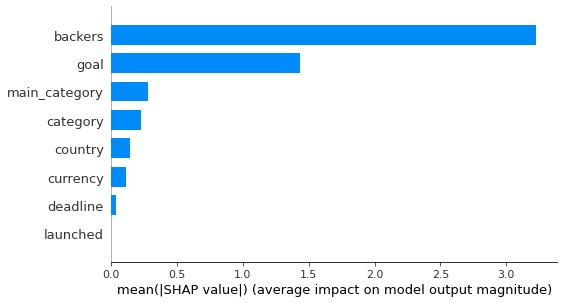

In [55]:
shap_values = model.get_feature_importance(
    Pool(X_test, label=y_test, cat_features=categorical_features_indices),
    type="ShapValues",
)
shap_values = shap_values[:, :-1]
 
 
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [66]:
df_extended = df.copy()
df_extended[
    "number_special_character_name"
] = df_extended.name.str.count('[-()"#/@;:&lt;&gt;{}`+=~|.!?,]')

In [79]:
df_extended["name"].str.split()

0                    [The, Songs, of, Adelaide, &, Abullah]
1                                        [Where, is, Hank?]
2         [ToshiCapital, Rekordz, Needs, Help, to, Compl...
4                                  [Monarch, Espresso, Bar]
5         [Support, Solar, Roasted, Coffee, &, Green, En...
                                ...                        
323743                                            [Islanda]
323746                                         [The, Tribe]
323747    [Walls, of, Remedy-, New, lesbian, Romantic, C...
323748                         [BioDefense, Education, Kit]
323749              [Nou, Renmen, Ayiti!, We, Love, Haiti!]
Name: name, Length: 281302, dtype: object

In [83]:
df_extended["word_count"] = df_extended["name"].str.split().str.len()

Looking through the data, one can see that some projects are using special characters in their name. We are going to implement a new column number_special_character_name that is going to count the number of special characters per name

Also, we are going to change the deadline and launched column from the type object to datetime and thereby replace the columns. This is happening in order to get the new column delta_days, which consists out of the days between the “launched” date and the “deadline” date

In [86]:
df_extended["deadline"] = pd.to_datetime(df_extended["deadline"])
df_extended["launched"] = pd.to_datetime(df_extended["launched"])

df_extended["delta_days"] = (df_extended["deadline"] - df_extended["launched"]).dt.days

It is also interesting to see whether projects are more successful in certain months. Therefore, we are building the new column launched_month. The same for day of week and year

In [87]:
df_extended["launched_month"] = df_extended["launched"].dt.month
df_extended["day_of_week_launched"] = df_extended.launched.dt.dayofweek
df_extended["year_launched"] = df_extended.launched.dt.year
df_extended.drop(["deadline", "launched"], inplace=True, axis=1)

In [88]:
df_extended.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'goal',
       'pledged', 'state', 'backers', 'country', 'usd pledged', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'number_special_character_name', 'word_count', 'delta_days',
       'launched_month', 'day_of_week_launched', 'year_launched'],
      dtype='object')

In [89]:
df_extended = df_extended[
    [
        "ID",
        "category",
        "main_category",
        "currency",
        "goal",
        "country",
        "number_special_character_name",
        "word_count",
        "delta_days",
        "launched_month",
        "day_of_week_launched",
        "year_launched",
        "state",
    ]
]

Again, building the test and training dataset

In [91]:
X = df_extended[df_extended.columns[:-1]]
y = df_extended[df_extended.columns[-1:]]

In [93]:
## Label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [94]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=2022
)

Initializing the new model and setting the categorical columns. Afterwards, fitting the model

In [95]:
model = CatBoostClassifier(
    random_seed=42, logging_level="Silent", iterations=150
)
categorical_features_indices = np.where(X_train.dtypes == np.object)[0]
 
model.fit(
    X_train,
    y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
)
 
model.score(X_test, y_test)

0.693114357825886

The current model is a little bit worse than the first try, but the assumption is that we are now actually predicting on a more accurate database. A quick look at the bar plot containing the current feature importances, tells us that in fact goal is the most informative column now.

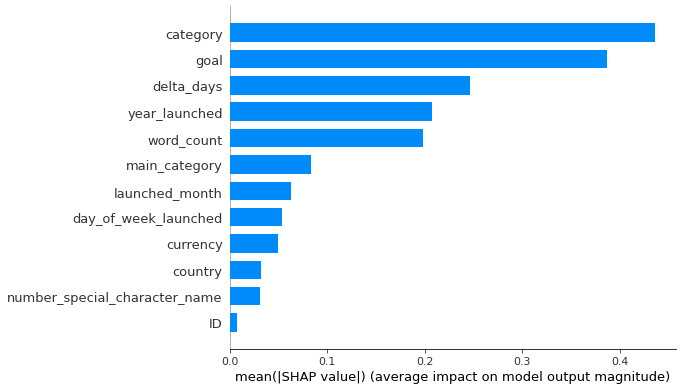

In [96]:
shap_values_ks = model.get_feature_importance(
    Pool(X_test, label=y_test, cat_features=categorical_features_indices),
    type="ShapValues",
)
shap_values_ks = shap_values_ks[:, :-1]
 
shap.summary_plot(shap_values_ks, X_test, plot_type="bar")

### Beauty of Shap - Summary plot

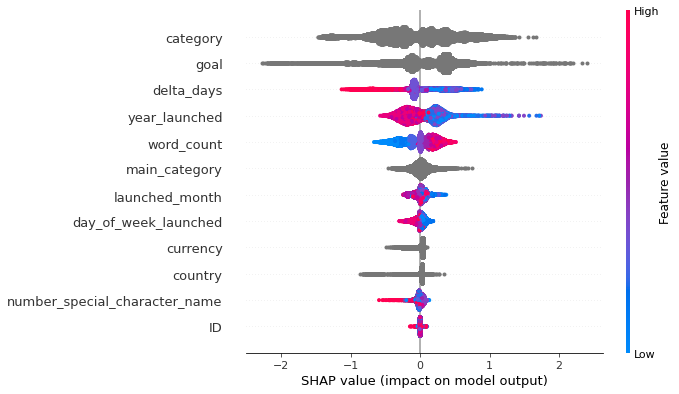

In [97]:
shap.summary_plot(shap_values_ks, X_test)